In [1]:
import mnist_util as mu
import numpy as np
from random import randint
from scipy.stats import multivariate_normal
from sklearn.metrics import zero_one_loss
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
# importing training images and test images
train, train_labels, test, test_labels = mu.get_np_array()

showing picture number: 54726


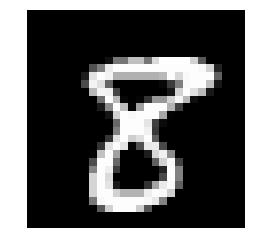

In [3]:
# show a random number in the trainings set
rnd = randint(0, len(train)-1)
print("showing picture number: {rnd}".format(rnd=rnd))
mu.show_a_num(train[rnd])

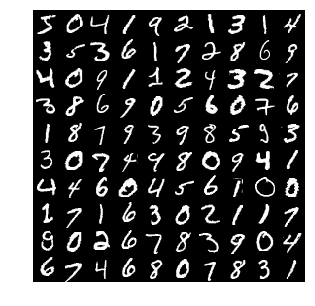

In [4]:
# show the first 100 images in the trainings data set
testing = train[:100]
mu.show_nums(testing, xsize=5, ysize=5)

In [5]:
# create arrays for only the specific numbers
num_arrays = mu.get_all_nums(train, train_labels)

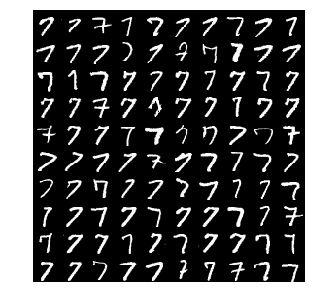

In [6]:
# show the first 100 images of number 7
num = num_arrays[7]
mu.show_nums(num[:100], xsize=5, ysize=5)

In [7]:
# calculate means for all numbers
mys = [np.mean(num_arrays[i], axis=0) for i in range(10)]

# calculate sigma (I, variance * I , covariance matrix) for all numbers
sigma_id  = np.identity(784)
sigma_var = [np.var(num_arrays[i]) for i in range(10)]
sigma_cov = [np.cov(num_arrays[i].T) for i in range(10)]

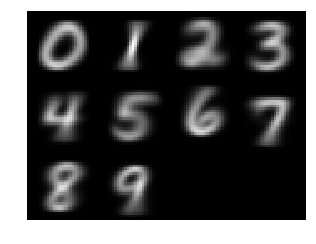

In [8]:
# print mean for each number
mu.show_nums(np.array(mys), xsize=5, ysize=5)

In [9]:
# calculate pdf's for all numbers with the different sigma
p_id  = [multivariate_normal(mean=mys[i], cov=sigma_id)     for i in range(10)]
p_var = [multivariate_normal(mean=mys[i], cov=sigma_var[i]) for i in range(10)]
p_cov = [multivariate_normal(mean=mys[i], cov=sigma_cov[i], allow_singular=True) for i in range(10)]

ValueError: operands could not be broadcast together with shapes (200,200,2) (784,) 

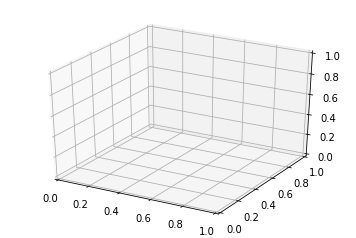

In [10]:
# trying to 3d plot the pdf (doesn't work...)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

p0_id  = p_id[0]
p0_var = p_var[0]
p0_cov = p_cov[0]

X, Y = np.mgrid[-10:10:.1, -10:10:.1]
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, p0_id.logpdf(pos),cmap='viridis',linewidth=0)

In [21]:
# print result of logpdf for all the different numbers of the first test image
for i in range(10):
    print("Logpdf of number {num}".format(num=i))
    print(p_id[i].logpdf(test[0]))
    print(p_var[i].logpdf(test[0]))
    print(p_cov[i].logpdf(test[0]))
    print()
print("Real number is {}".format(test_labels[0]))

Logpdf of number 0
-2356569.03402
-4536.2583174
-5584.07995324

Logpdf of number 1
-2013992.94458
-4478.65120041
-48275.1532546

Logpdf of number 2
-2003728.14354
-4475.84372955
-11373.1489888

Logpdf of number 3
-1937864.3268
-4461.11301603
-4601.72829555

Logpdf of number 4
-1596458.20195
-4391.58368438
-3364.74468294

Logpdf of number 5
-1717303.32433
-4416.63293609
-3378.23830066

Logpdf of number 6
-2199405.96183
-4499.87218429
-127412.168834

Logpdf of number 7
-746518.593378
-4233.67321789
-2062.52018444

Logpdf of number 8
-1924440.82574
-4463.90478032
-18897.6400447

Logpdf of number 9
-1339429.01011
-4348.15816743
-2375.04346229

Real number is 7


In [22]:
# print the predicted number of the first 5 test images with the different simga
for idx, a in enumerate(test[:5]):
    real = test_labels[idx]
    
    # calculate logpdf of every number for test image
    pdf_id  = [p_id[i].logpdf(a) for i in range(10)]
    pdf_var = [p_var[i].logpdf(a) for i in range(10)]
    pdf_cov = [p_cov[i].logpdf(a) for i in range(10)]
    
    # find max result of logpdf which index equals the predicted number
    max_id  = max(pdf_id)
    max_var = max(pdf_var)
    max_cov = max(pdf_cov)

    print(idx)
    print("Id  guess: {}".format(pdf_id.index(max_id)))
    print("Var guess: {}".format(pdf_var.index(max_var)))
    print("Cov guess: {}".format(pdf_cov.index(max_cov)))
    print("Answer: ...{}...".format(real))
    print()

0
Id  guess: 7
Var guess: 7
Cov guess: 7
Answer: ...7...

1
Id  guess: 2
Var guess: 2
Cov guess: 2
Answer: ...2...

2
Id  guess: 1
Var guess: 1
Cov guess: 1
Answer: ...1...

3
Id  guess: 0
Var guess: 0
Cov guess: 0
Answer: ...0...

4
Id  guess: 4
Var guess: 4
Cov guess: 4
Answer: ...4...



In [23]:
# calculate predicted numbers for all test images
result_id  = []
result_var = []
result_cov = []
for idx, val in enumerate(test):
    # set logpdf of 0 as max at start
    max_id  = (0, p_id[0].logpdf(val))
    max_var = (0, p_var[0].logpdf(val))
    max_cov = (0, p_cov[0].logpdf(val))
    for i in range(1, 10):
        # calculate logpdf for every number in 1 - 9
        pdf_id  = (i, p_id[i].logpdf(val))
        pdf_var = (i, p_var[i].logpdf(val))
        pdf_cov = (i, p_cov[i].logpdf(val))
        
        # check if logpdf > max and save max
        if pdf_id[1]  > max_id[1]:
            max_id = pdf_id
        if pdf_var[1] > max_var[1]:
            max_var = pdf_var
        if pdf_cov[1] > max_cov[1]:
            max_cov = pdf_cov

    # append predicted number to result vector
    result_id.append(max_id[0])
    result_var.append(max_var[0])
    result_cov.append(max_cov[0])

In [24]:
# calculate zero-one-loss
loss_id  = zero_one_loss(test_labels, result_id)
loss_var = zero_one_loss(test_labels, result_var)
loss_cov = zero_one_loss(test_labels, result_cov)

print("Loss Id:  {}".format(loss_id))
print("Loss Var: {}".format(loss_var))
print("Loss Cov: {}".format(loss_cov))

Loss Id:  0.17969999999999997
Loss Var: 0.22419999999999995
Loss Cov: 0.18620000000000003


In [25]:
# calculate confusion matrix
cm_id  = confusion_matrix(test_labels, result_id)
cm_var = confusion_matrix(test_labels, result_var)
cm_cov = confusion_matrix(test_labels, result_cov)
classes = np.arange(10)

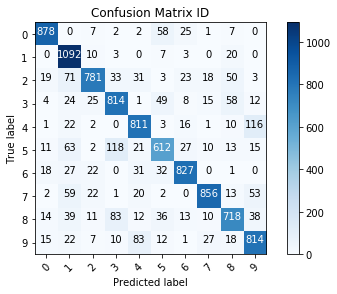

In [26]:
# print confusion matrix for sigma = I
mu.plot_confusion_matrix(cm_id, title='Confusion Matrix ID', classes=classes)

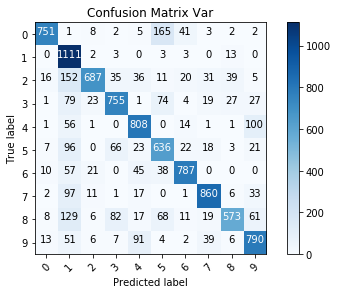

In [27]:
# print confusion matrix for sigma = var * I
mu.plot_confusion_matrix(cm_var, title='Confusion Matrix Var', classes=classes)

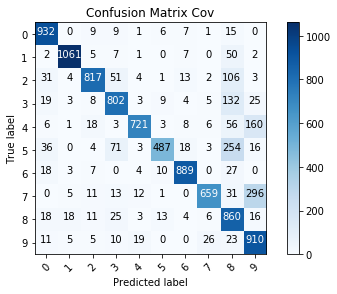

In [28]:
# print confusion matrix for sigma = covariance matrix
mu.plot_confusion_matrix(cm_cov, title='Confusion Matrix Cov', classes=classes)